<a id="top"></a>
# Vegetation Change

This notebook uses changes in the Normalized Difference Vegetation Index (NDVI) to identify vegetation change. The algorithm identifies a "baseline" and "analysis" time period and then compares the spectral index in each of those time periods. Significant changes in NDVI (vegetation greenness) are coincident with land change, as long as the comparisons are done between similar time periods (seasons or years). Users of this algorithm should not accept the accuracy of the results but should conduct ground validation testing to assess accuracy. It is expected that this algorithm can be used to identify clusters of pixels that have experienced change and allow targeted investigation of those areas by local or regional governments. In some cases the impacts may be negative (deforestation, mining, burning, drought) or positive (regrowth, improved soil moisture). 

It should also be noted that the selection of the baseline and analysis time period is critical. First, the two time periods should be similar (season, year) so that the vegetation state can be compared in similar weather conditions. Second, the time periods should be sufficient clear (non-cloudy) data. If the baseline or analysis mosaic (composite of images) is contaminated with clouds, it will impact the results. 

## <span id="connect_dc">Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
import warnings
# Supress Warning 
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = api.dc

## <span id="plat_prod">Choose Platforms and Products [&#9652;](#top)</span>

In [2]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal
# Landsat-8 data is much better than Landsat-7 due to issues with "banding"

# product = "ls7_ledaps_kenya"
# platform = "LANDSAT_7"

# product = "ls8_lasrc_kenya"
# platform = "LANDSAT_8"

# product = "ls7_ledaps_ghana"
# platform = "LANDSAT_7"

product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
# Print extents of the data cube
extents = api.get_full_dataset_extent(platform = platform, product = product)
latitude_extents = (min(extents['latitude'].values),max(extents['latitude'].values))
longitude_extents = (min(extents['longitude'].values),max(extents['longitude'].values))
time_extents = (min(extents['time'].values),max(extents['time'].values))
print(time_extents)
print(latitude_extents)
print(longitude_extents)

(numpy.datetime64('2013-04-13T10:10:55.000000000'), numpy.datetime64('2020-01-27T10:09:38.000000000'))
(3.7730589405966173, 11.318637832619382)
(-3.772789446011382, 1.8863273493593828)


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [4]:
# Select an analysis region 

# Mau Forest - Western Kenya
# Baseline = 5/30/2013, Analysis = 5/25/2017
# latitude = (-0.13406, 0.21307)
# longitude = (35.28322, 35.56681)

# Mining Region near Obuasi, Ghana (small region)
# Baseline = 12/23/13, Analysis = 1/6/19
latitude = (6.0985, 6.2675)
longitude = (-2.050, -1.8629)

In [5]:
## The code below renders a map that can be used to orient yourself with the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

## <span id="define_analysis_params">Define Analysis Parameters [&#9652;](#top)</span>  

In [6]:
from datetime import datetime

# Select the start and end periods for your analysis products
# The datetime function is (Year,Month,Day)
# These time windows will be used to make a mosaic, so typically pick a year length (or more)
# or select a small window surrounding a clear single date (use Cloud Statistics notebook)
# Also, be sure to evaluate the RGB mosaics (below) to affirm they are not full of clouds

# Select the baseline time period (start and end)
baseline_time_period = (datetime(2013,12,22), datetime(2013,12,24))

# Select the analysis time period (start and end)
analysis_time_period = (datetime(2019,1,5), datetime(2019,1,7))

# Select the cloud-free mosaic type
# Options are: max_ndvi, median, most_recent_pixel
# Use "median" for longer time periods, such as a year
# Use "most_recent_pixel" for short time periods, such as one day
# Use "max_ndvi" for seasonal time periods to compare vegetation peaks

baseline_mosaic_function = "most_recent_pixel" 
analysis_mosaic_function = "most_recent_pixel" 

## <span id="load_data">Load and Clean Data from the Data Cube [&#9652;](#top)</span>  

In [7]:
baseline_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                      time=baseline_time_period) 

In [8]:
analysis_ds = dc.load(latitude=latitude,longitude=longitude,platform=platform,product=product,
                      measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'],
                      time=analysis_time_period) 

In [9]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask_baseline = landsat_qa_clean_mask(baseline_ds, platform=platform)
baseline_ds = baseline_ds.where(cloud_mask_baseline)

cloud_mask_analysis = landsat_qa_clean_mask(analysis_ds, platform=platform)
analysis_ds = analysis_ds.where(cloud_mask_analysis)

## Create a Mosaic for the Baseline and Analysis Time Periods

In [10]:
from utils_special.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic, create_median_mosaic, create_mosaic
mosaic_function = {"median": create_median_mosaic,
                   "max_ndvi": create_max_ndvi_mosaic,
                   "most_recent_pixel": create_mosaic}

In [11]:
baseline_compositor = mosaic_function[baseline_mosaic_function]
analysis_compositor = mosaic_function[analysis_mosaic_function]

In [12]:
baseline_composite = baseline_compositor(baseline_ds, cloud_mask_baseline.values)
analysis_composite = analysis_compositor(analysis_ds, cloud_mask_analysis.values)

## <span id="anomalies">Calculate Anomaly Product [&#9652;](#top)</span>  

In [13]:
def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [14]:
parameter_baseline_composite = NDVI(baseline_composite)
parameter_analysis_composite = NDVI(analysis_composite)
parameter_anomaly = parameter_analysis_composite - parameter_baseline_composite

## Show Baseline RGB, Analysis RGB and Anomaly Products

In [15]:
import matplotlib.pyplot as plt
from utils.data_cube_utilities.dc_rgb import rgb
from matplotlib.cm import RdYlGn
RdYlGn.set_bad('black',1.)

In [16]:
# Define the significant anomaly range for Plot #4
loss_range  = parameter_anomaly < -0.2
gain_range  = parameter_anomaly > 0.2

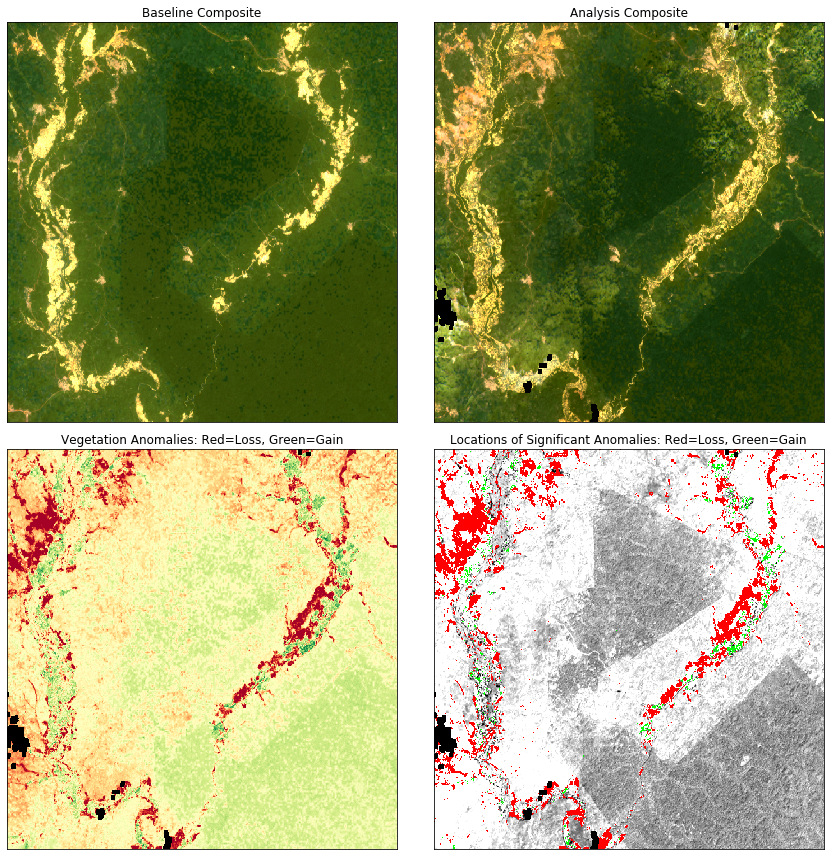

In [17]:
import xarray as xr
import numpy as np

fig, ax = plt.subplots(2, 2, figsize=(12,12))

for sub_ax in ax.flatten():
    sub_ax.set_facecolor('black')

baseline_rgb = baseline_composite[['red', 'green', 'blue']].to_array()
analysis_rgb = analysis_composite[['red', 'green', 'blue']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
lw_qtl, up_qtl = 0.02, 0.98
rgb_vmin = min(baseline_rgb.quantile(lw_qtl).values,analysis_rgb.quantile(lw_qtl).values)
rgb_vmax = max(baseline_rgb.quantile(up_qtl).values,analysis_rgb.quantile(up_qtl).values)

# Plot the resulting 4 products ... Baseline RGB, Analysis RGB, Total Anomaly, Anomaly Threshold
# NOTE: Clouds in either the baseline or analysis images will be removed from the anomaly product

## Plot #1 = Baseline RGB (upper left)
axes_image = baseline_rgb.plot.imshow(ax=ax[0,0], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #2 = Analysis RGB (upper right)
analysis_rgb.plot.imshow(ax=ax[0,1], vmin=rgb_vmin, vmax=rgb_vmax)

## Plot #3 = Total Anomaly (lower left)
parameter_anomaly.plot(ax=ax[1,0], vmin=-0.4, vmax=0.4, cmap = RdYlGn, add_colorbar=False)

## Plot #4 = Anomaly Threshold (lower right)

# Analysis composite grayscale background
plt4_bkg_band = 'swir1' # The band to use as the background image.
plt4_rgb = np.repeat(analysis_composite[plt4_bkg_band].where(cloud_mask_baseline.squeeze('time'))\
                     .values[:,:,np.newaxis],3,axis=2)

# Selected a range of SWIR1 values (0.001 to 0.600) to lighten image background (vs. 0.02 and 0.98)
min_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.001)
max_bkg = np.nanquantile(analysis_composite[plt4_bkg_band].values, 0.600)
plt4_rgb = np.interp(plt4_rgb, (min_bkg, max_bkg), [0,1])

# Significant anomaly color overlays
color_green = np.array([0,1,0]) # green
color_red   = np.array([1,0,0]) # red
plt4_rgb[loss_range] = color_red
plt4_rgb[gain_range] = color_green

# Plot
plt4_coords = dict(analysis_composite.coords)
rgb_coord_arr = np.array(['red', 'green', 'blue'])
rgb_coord_da = xr.DataArray(rgb_coord_arr,name='rgb',dims=['rgb'],coords={'rgb': rgb_coord_arr})
plt4_coords.update({'rgb': rgb_coord_da})
plt4_rgb_da = xr.DataArray(plt4_rgb, coords=plt4_coords,dims=list(analysis_composite.dims) + ['rgb'])
plt4_rgb_da.plot.imshow(ax=ax[1,1])

# Titles for all plots
ax[0,0].set_title('Baseline Composite'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('Analysis Composite'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('Vegetation Anomalies: Red=Loss, Green=Gain'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('Locations of Significant Anomalies: Red=Loss, Green=Gain'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)

plt.tight_layout()
plt.show()

## Calculate Pixel Counts within Thresholds

In [18]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask) 
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


In [19]:
# Select an Anomaly Threshold Range to calculate the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)
# This code block can be used for either vegetation loss or vegetation gain calculations

# NDVI losses might use the following limits: min=-1.0 and max=-0.2
# NDVI gains might use the following limits: min=0.2, max=1.0

minimum_change = -0.7
maximum_change = -0.2

In [20]:
# This output is a count of the pixels that fall within each threshold range

threshold_count(parameter_anomaly,minimum_change,maximum_change)

{'total': 436460,
 'total_non_cloudy': 433720,
 'inside': 26826,
 'outside': 406894}

In [21]:
# This output is a percentage of the pixels that fall within each threshold range

threshold_percentage(parameter_anomaly,minimum_change,maximum_change)

{'percent_inside_threshold': 6.146267699216423,
 'percent_outside_threshold': 93.22595426843239,
 'percent_clouds': 0.6277780323511877}